Cell 1 — Install packages

In [1]:
# Install required packages (run once)
%pip install -q mne PyWavelets scikit-learn seaborn imbalanced-learn
%pip install -q azureml-core azure-ai-ml azure-identity

print("✅ Packages installed (if no errors above).")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ Packages installed (if no errors above).


Cell 2 — Load libraries + set seeds

In [2]:
# Basic utilities
import os
import random
import pickle

# Arrays
import numpy as np

# EEG processing
import mne
import pywt

# ML tools
from sklearn.decomposition import FastICA
from sklearn.metrics import confusion_matrix, roc_auc_score

# Balancing
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Helpers
from typing import Optional, Union, Sequence, Dict, Tuple, List

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

try:
    tf.keras.utils.enable_interactive_logging()
except Exception:
    pass

# Set seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Imports done + seeds set.")


2026-01-26 07:55:36.819359: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-26 07:55:37.085817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769414137.192649   41149 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769414137.222037   41149 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769414137.455355   41149 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

✅ Imports done + seeds set.


Cell 3 — Azure download + load AD arrays + build labels (EXCLUDING last 5)

In [3]:
from azureml.core import Workspace, Datastore, Dataset

print("[STEP 1] Connecting to Azure ML workspace...")

subscription_id = "eccc04ba-d8b0-4f70-864a-b4a6753bfc72"
resource_group  = "somnasnest"
workspace_name  = "SomnasNest"
folder_path = "UI/2026-01-17_162622_UTC/Data Array/"

ws = Workspace.get(
    name=workspace_name,
    subscription_id=subscription_id,
    resource_group=resource_group
)
print("[STEP 1] Workspace connected ✅")

datastore = ws.get_default_datastore()
print("[STEP 1] Default datastore loaded ✅")

ds = Dataset.File.from_files(path=(datastore, folder_path))
print("[STEP 1] FileDataset created ✅")

local_dir = "./_ad_data_array"
os.makedirs(local_dir, exist_ok=True)

print(f"[STEP 1] Downloading data to: {local_dir} ...")
ds.download(target_path=local_dir, overwrite=True)
print("[STEP 1] Download complete ✅")

arrays = {}
print("[STEP 1] Loading .npy files...")
for root, _, files in os.walk(local_dir):
    for f in files:
        p = os.path.join(root, f)
        if f.lower().endswith(".npy"):
            arrays[f] = np.load(p, allow_pickle=False)

if "ad_negative.npy" not in arrays or "ad_positive.npy" not in arrays:
    raise FileNotFoundError("❌ Could not find ad_negative.npy and ad_positive.npy in downloaded folder.")

X_neg_full = arrays["ad_negative.npy"].astype(np.float32)  # (31,127,150000)
X_pos_full = arrays["ad_positive.npy"].astype(np.float32)  # (46,127,150000)

print("✅ Arrays loaded:")
print("  ad_negative.npy (full):", X_neg_full.shape)
print("  ad_positive.npy (full):", X_pos_full.shape)

# ✅ Modification #1: drop last 5 trials from BOTH arrays
if X_neg_full.shape[0] <= 5 or X_pos_full.shape[0] <= 5:
    raise ValueError("❌ One of the arrays has <= 5 trials; cannot drop last 5 safely.")

X_neg = X_neg_full[:-5]
X_pos = X_pos_full[:-31]

print("✅ After removing last 5 trials:")
print("  ad_negative.npy:", X_neg.shape)
print("  ad_positive.npy:", X_pos.shape)

# Labels
y_neg = np.zeros((X_neg.shape[0],), dtype=np.int32)
y_pos = np.ones((X_pos.shape[0],), dtype=np.int32)

X_all_trials = np.concatenate([X_neg, X_pos], axis=0)
y_all_trials = np.concatenate([y_neg, y_pos], axis=0)

print("[STEP 1] Combined dataset:")
print("  X_all_trials:", X_all_trials.shape)
print("  y_all_trials:", y_all_trials.shape)
print("  Class counts:", np.unique(y_all_trials, return_counts=True))


[STEP 1] Connecting to Azure ML workspace...
[STEP 1] Workspace connected ✅
[STEP 1] Default datastore loaded ✅
[STEP 1] FileDataset created ✅
[STEP 1] Downloading data to: ./_ad_data_array ...
{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}
[STEP 1] Download complete ✅
[STEP 1] Loading .npy files...
✅ Arrays loaded:
  ad_negative.npy (full): (31, 127, 150000)
  ad_positive.npy (full): (46, 127, 150000)
✅ After removing last 5 trials:
  ad_negative.npy: (26, 127, 150000)
  ad_positive.npy: (15, 127, 150000)
[STEP 1] Combined dataset:
  X_all_trials: (41, 127, 150000)
  y_all_trials: (41,)
  Class counts: (array([0, 1], dtype=int32), array([26, 15]))


Class DeploymentTemplateOperations: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


* downsample to 500 Hz

In [4]:
import numpy as np
import mne

sfreq_in = 1000
sfreq_out = 500

# Cast to float64 for MNE, then back to float32 if you want
X_all_trials_ds = mne.filter.resample(
    X_all_trials.astype(np.float64, copy=False),
    down=sfreq_in // sfreq_out,   # 2
    npad="auto",
    axis=-1,
    verbose=True
).astype(np.float32, copy=False)

print("Before:", X_all_trials.shape, X_all_trials.dtype)
print("After: ", X_all_trials_ds.shape, X_all_trials_ds.dtype)


Before: (41, 127, 150000) float32
After:  (41, 127, 75000) float32


Cell 4 — Helper + leakage-safe preprocessing classes

In [5]:
def _names_from_index_mapping(n_channels, index_to_name):
    if index_to_name is None:
        return [f"EEG{i+1}" for i in range(n_channels)]
    keys = list(index_to_name.keys())
    is_zero_based = (0 in keys) and (1 not in keys)
    names = []
    for i in range(n_channels):
        key = i if is_zero_based else (i + 1)
        names.append(index_to_name.get(key, f"EEG{i+1}"))
    return names

def _make_raw(eeg, sfreq, ch_names, use_standard_1020=True):
    ch_types = ['eog' if str(n).upper().startswith("EOG") else 'eeg' for n in ch_names]
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(eeg.astype(np.float32, copy=False), info, verbose=False)

    montage_applied = False
    if use_standard_1020:
        try:
            mont = mne.channels.make_standard_montage("standard_1020")
            raw.set_montage(mont, match_case=False, on_missing="ignore")
            montage_applied = True
        except Exception:
            montage_applied = False

    return raw, montage_applied

class WaveletICA:
    def __init__(self, wavelet="db4", level=3, n_components=10, random_state=42):
        self.wavelet = wavelet
        self.level = level
        self.n_components = n_components
        self.random_state = random_state
        self.ica_ = None
        self._n_ch = None

    def fit(self, X):
        C = X.shape[0]
        self._n_ch = C
        coeffs = pywt.wavedec(X, wavelet=self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        k = int(min(self.n_components, C))
        self.ica_ = FastICA(n_components=k, random_state=self.random_state)
        S = self.ica_.fit_transform(A.T)
        A_denoised = self.ica_.inverse_transform(S).T
        coeffs[0] = A_denoised
        _ = pywt.waverec(coeffs, wavelet=self.wavelet, axis=1)
        return self

    def transform(self, X):
        assert self.ica_ is not None, "WaveletICA not fitted yet."
        coeffs = pywt.wavedec(X, wavelet=self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        S = self.ica_.transform(A.T)
        A_denoised = self.ica_.inverse_transform(S).T
        coeffs[0] = A_denoised
        Y = pywt.waverec(coeffs, wavelet=self.wavelet, axis=1)

        if Y.shape[1] < X.shape[1]:
            Y = np.pad(Y, ((0, 0), (0, X.shape[1] - Y.shape[1])), mode="constant")
        elif Y.shape[1] > X.shape[1]:
            Y = Y[:, :X.shape[1]]

        return Y.astype(np.float32, copy=False)

class EEGPreprocessor:
    def __init__(
        self,
        *,
        index_to_name=None,
        use_standard_1020=True,
        resample_to=None,
        notch_freqs=50.0,
        highpass=0.05,
        bad_point_z=6.0,
        bad_channel_z=5.0,
        interpolate_bad_channels=False,
        car=True,
        use_wica=True,
        wica_components=10,
        wica_wavelet="db4",
        wica_level=3,
        wica_random_state=42
    ):
        self.index_to_name = index_to_name
        self.use_standard_1020 = use_standard_1020
        self.resample_to = resample_to
        self.notch_freqs = notch_freqs
        self.highpass = highpass
        self.bad_point_z = bad_point_z
        self.bad_channel_z = bad_channel_z
        self.interpolate_bad_channels = interpolate_bad_channels
        self.car = car
        self.use_wica = use_wica

        self._sfreq_out = None
        self._train_mu = None
        self._train_sd = None

        self._wica = WaveletICA(
            wavelet=wica_wavelet,
            level=wica_level,
            n_components=wica_components,
            random_state=wica_random_state
        )

    @property
    def sfreq_out(self):
        assert self._sfreq_out is not None, "Preprocessor not run yet."
        return float(self._sfreq_out)

    def _filter_and_reference(self, raw):
        if self.resample_to is not None and float(self.resample_to) != float(raw.info["sfreq"]):
            raw.resample(self.resample_to, npad="auto")
        self._sfreq_out = float(raw.info["sfreq"])

        if self.notch_freqs is not None:
            raw.notch_filter(freqs=self.notch_freqs, verbose=False)

        if self.highpass is not None:
            raw.filter(l_freq=self.highpass, h_freq=None, verbose=False)

        if self.car:
            raw.set_eeg_reference("average", projection=True)
            raw.apply_proj()

    def _repair_transients_with_train_stats(self, raw):
        X = raw.get_data()
        mu = self._train_mu
        sd = self._train_sd
        assert mu is not None and sd is not None, "Training stats not set."

        hi = mu + self.bad_point_z * sd
        lo = mu - self.bad_point_z * sd
        mask = (X > hi) | (X < lo)

        if np.any(mask):
            X_fixed = X.copy()
            t = np.arange(X.shape[1], dtype=float)
            for ch in range(X.shape[0]):
                m = mask[ch]
                if m.any():
                    good = ~m
                    if good.sum() >= 2:
                        X_fixed[ch, m] = np.interp(t[m], t[good], X_fixed[ch, good])
            raw._data = X_fixed

    def fit(self, X_train, sfreq):
        C = X_train.shape[0]
        ch_names = _names_from_index_mapping(C, self.index_to_name)

        raw_train, _ = _make_raw(X_train, sfreq, ch_names, self.use_standard_1020)
        self._filter_and_reference(raw_train)

        Xt = raw_train.get_data()
        self._train_mu = Xt.mean(axis=1, keepdims=True)
        self._train_sd = Xt.std(axis=1, keepdims=True) + 1e-12

        if self.use_wica:
            self._wica.fit(Xt)

        return self

    def transform(self, X, sfreq):
        C = X.shape[0]
        ch_names = _names_from_index_mapping(C, self.index_to_name)

        raw, _ = _make_raw(X, sfreq, ch_names, self.use_standard_1020)
        self._filter_and_reference(raw)
        self._repair_transients_with_train_stats(raw)

        Xf = raw.get_data()
        if self.use_wica:
            Xf = self._wica.transform(Xf)

        return Xf.astype(np.float32, copy=False), self.sfreq_out

    def fit_transform(self, X_train, sfreq):
        self.fit(X_train, sfreq)
        X_clean, fs_out = self.transform(X_train, sfreq)
        return X_clean, fs_out

print("✅ Preprocessing classes loaded.")


✅ Preprocessing classes loaded.


Cell 5 — Set sampling frequency + Preprocess all trials

In [6]:
print("[STEP 2] Starting preprocessing...")

fs = 500.0  # <-- CHANGE if needed
print(f"[STEP 2] Using fs={fs} Hz")

CHANNEL_MAP = None

pre = EEGPreprocessor(
    index_to_name=CHANNEL_MAP,
    use_standard_1020=True,
    resample_to=None,
    notch_freqs=[50.0, 100.0, 150.0],
    highpass=0.05,
    bad_point_z=6.0,
    bad_channel_z=5.0,
    interpolate_bad_channels=False,
    car=True,
    use_wica=True,
    wica_components=10,
    wica_wavelet="db4",
    wica_level=3,
    wica_random_state=42
)

max_calib_trials = min(10, X_all_trials.shape[0])
print(f"[STEP 2] Fitting preprocessor on first {max_calib_trials} trials...")

calib_trials = X_all_trials[:max_calib_trials]
X_calib = np.concatenate(calib_trials, axis=1).astype(np.float32, copy=False)

X_calib_clean, fs_out = pre.fit_transform(X_calib, fs)
print(f"[STEP 2] Preprocessor fitted ✅ | fs_out={fs_out} Hz")

data_clean = []
for i in range(X_all_trials.shape[0]):
    X_clean, _ = pre.transform(X_all_trials[i], fs)
    data_clean.append(X_clean.astype(np.float32, copy=False))
    if (i + 1) % 5 == 0 or (i + 1) == X_all_trials.shape[0]:
        print(f"[STEP 2] Preprocessed {i+1}/{X_all_trials.shape[0]} trials...")

data_clean = np.array(data_clean, dtype=np.float32)

print("[STEP 2] Done preprocessing ✅")
print("  data_clean shape:", data_clean.shape)
print("  labels shape    :", y_all_trials.shape)
print("  class counts    :", np.unique(y_all_trials, return_counts=True))


[STEP 2] Starting preprocessing...
[STEP 2] Using fs=500.0 Hz
[STEP 2] Fitting preprocessor on first 10 trials...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
[STEP 2] Preprocessor fitted ✅ | fs_out=500.0 Hz
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been app

Cell 6 — Augmentation

In [7]:
print("[STEP 3] Starting augmentation (segmentation)...")

def augment_data(trial_data, label, segment_size=100):
    segments = []
    labels = []
    n_segments = trial_data.shape[1] // segment_size
    for i in range(n_segments):
        seg = trial_data[:, i*segment_size:(i+1)*segment_size]
        segments.append(seg.astype(np.float32, copy=False))
        labels.append(int(label))
    return segments, labels

augmented = []
aug_targets = []

for idx, (trial, y) in enumerate(zip(data_clean, y_all_trials), start=1):
    segs, ys = augment_data(trial, y, segment_size=100)
    augmented.extend(segs)
    aug_targets.extend(ys)
    if idx % 5 == 0 or idx == len(data_clean):
        print(f"[STEP 3] Segmented {idx}/{len(data_clean)} trials...")

augmented = np.array(augmented, dtype=np.float32)   # (N,127,100)
aug_targets = np.array(aug_targets, dtype=np.int32)

print("[STEP 3] Augmentation done ✅")
print("  augmented shape:", augmented.shape)
print("  aug_targets shape:", aug_targets.shape)
print("  class counts:", np.unique(aug_targets, return_counts=True))


[STEP 3] Starting augmentation (segmentation)...
[STEP 3] Segmented 5/41 trials...
[STEP 3] Segmented 10/41 trials...
[STEP 3] Segmented 15/41 trials...
[STEP 3] Segmented 20/41 trials...
[STEP 3] Segmented 25/41 trials...
[STEP 3] Segmented 30/41 trials...
[STEP 3] Segmented 35/41 trials...
[STEP 3] Segmented 40/41 trials...
[STEP 3] Segmented 41/41 trials...
[STEP 3] Augmentation done ✅
  augmented shape: (61500, 127, 100)
  aug_targets shape: (61500,)
  class counts: (array([0, 1], dtype=int32), array([39000, 22500]))


Cell 7 — “Fair selection”

In [8]:
'''print("[STEP 4] Fair selection step...")

class_data = {0: [], 1: []}
for x, y in zip(augmented, aug_targets):
    class_data[int(y)].append(x)

max_per_class = 20000

selected_data = []
selected_targets = []

for cls in [0, 1]:
    picked = class_data[cls][:max_per_class]
    selected_data.extend(picked)
    selected_targets.extend([cls] * len(picked))
    print(f"[STEP 4] Picked {len(picked)} samples for class {cls}")

selected_data = np.array(selected_data, dtype=np.float32)   # (N,C,T)
selected_targets = np.array(selected_targets, dtype=np.int32)

print("[STEP 4] Selection done ✅")
print("  selected_data shape:", selected_data.shape)
print("  selected_targets shape:", selected_targets.shape)
print("  class counts:", np.unique(selected_targets, return_counts=True))
'''

'print("[STEP 4] Fair selection step...")\n\nclass_data = {0: [], 1: []}\nfor x, y in zip(augmented, aug_targets):\n    class_data[int(y)].append(x)\n\nmax_per_class = 20000\n\nselected_data = []\nselected_targets = []\n\nfor cls in [0, 1]:\n    picked = class_data[cls][:max_per_class]\n    selected_data.extend(picked)\n    selected_targets.extend([cls] * len(picked))\n    print(f"[STEP 4] Picked {len(picked)} samples for class {cls}")\n\nselected_data = np.array(selected_data, dtype=np.float32)   # (N,C,T)\nselected_targets = np.array(selected_targets, dtype=np.int32)\n\nprint("[STEP 4] Selection done ✅")\nprint("  selected_data shape:", selected_data.shape)\nprint("  selected_targets shape:", selected_targets.shape)\nprint("  class counts:", np.unique(selected_targets, return_counts=True))\n'

In [9]:
selected_data = augmented
selected_targets = aug_targets

Cell 8 — Reshape for EEGNet input

In [10]:
print("[STEP 5] Reshaping data for EEGNet...")

X_all = selected_data[..., np.newaxis].astype(np.float32, copy=False)  # (N,C,T,1)
y_all = selected_targets.astype(np.int32, copy=False)

print("[STEP 5] Done ✅")
print("  X_all shape:", X_all.shape)
print("  y_all shape:", y_all.shape)
print("  class counts:", np.unique(y_all, return_counts=True))


[STEP 5] Reshaping data for EEGNet...
[STEP 5] Done ✅
  X_all shape: (61500, 127, 100, 1)
  y_all shape: (61500,)
  class counts: (array([0, 1], dtype=int32), array([39000, 22500]))


Cell 9 — Train-only normalization on FULL DATA + save mean/std as PKL

In [11]:
print("=" * 80)
print("[UPDATED STEP 6] Train/Val Split BEFORE normalization + compute stats on TRAIN only")
print("=" * 80)

from sklearn.model_selection import train_test_split

# Use the segmented dataset you already created
# selected_data = augmented
# selected_targets = aug_targets

print("[STEP 6] Preparing X_all, y_all ...")
X_all = selected_data[..., np.newaxis].astype(np.float32, copy=False)  # (N,C,T,1)
y_all = selected_targets.astype(np.int32, copy=False)                 # (N,)

print("[STEP 6] X_all shape:", X_all.shape)
print("[STEP 6] y_all shape:", y_all.shape)
print("[STEP 6] Class counts:", dict(zip(*np.unique(y_all, return_counts=True))))

print("\n[STEP 6] Splitting into train/val BEFORE SMOTE ...")
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_all, y_all,
    test_size=0.20,
    random_state=42,
    stratify=y_all
)

print("[STEP 6] Split done ✅")
print("  X_train_raw:", X_train_raw.shape, "| y_train_raw:", y_train_raw.shape)
print("  X_val_raw  :", X_val_raw.shape,   "| y_val_raw  :", y_val_raw.shape)

print("\n[STEP 6] Class distribution check:")
print("  Train:", dict(zip(*np.unique(y_train_raw, return_counts=True))))
print("  Val  :", dict(zip(*np.unique(y_val_raw, return_counts=True))))

# -----------------------------
# NORMALIZATION: fit on TRAIN only
# -----------------------------
print("\n[STEP 6] Computing normalization stats on TRAIN only ...")

eps = 1e-6
train_mean = np.mean(X_train_raw, axis=(0, 2, 3), keepdims=True).astype(np.float32)
train_std  = np.std(X_train_raw,  axis=(0, 2, 3), keepdims=True).astype(np.float32)
train_std  = np.maximum(train_std, eps)

print("[STEP 6] train_mean shape:", train_mean.shape)
print("[STEP 6] train_std  shape:", train_std.shape)

print("\n[STEP 6] Applying normalization to TRAIN and VAL ...")
X_train_norm = (X_train_raw - train_mean) / train_std
X_val_norm   = (X_val_raw   - train_mean) / train_std

print("[STEP 6] Normalization complete ✅")
print("  X_train_norm:", X_train_norm.shape)
print("  X_val_norm  :", X_val_norm.shape)

# Save stats (same as before, just after train-only fit)
print("\n[STEP 6] Saving normalization stats ...")
with open("train_mean.pkl", "wb") as f:
    pickle.dump(train_mean, f)

with open("train_std.pkl", "wb") as f:
    pickle.dump(train_std, f)

print("[STEP 6] Saved: train_mean.pkl, train_std.pkl ✅")


[UPDATED STEP 6] Train/Val Split BEFORE normalization + compute stats on TRAIN only
[STEP 6] Preparing X_all, y_all ...
[STEP 6] X_all shape: (61500, 127, 100, 1)
[STEP 6] y_all shape: (61500,)
[STEP 6] Class counts: {np.int32(0): np.int64(39000), np.int32(1): np.int64(22500)}

[STEP 6] Splitting into train/val BEFORE SMOTE ...
[STEP 6] Split done ✅
  X_train_raw: (49200, 127, 100, 1) | y_train_raw: (49200,)
  X_val_raw  : (12300, 127, 100, 1) | y_val_raw  : (12300,)

[STEP 6] Class distribution check:
  Train: {np.int32(0): np.int64(31200), np.int32(1): np.int64(18000)}
  Val  : {np.int32(0): np.int64(7800), np.int32(1): np.int64(4500)}

[STEP 6] Computing normalization stats on TRAIN only ...
[STEP 6] train_mean shape: (1, 127, 1, 1)
[STEP 6] train_std  shape: (1, 127, 1, 1)

[STEP 6] Applying normalization to TRAIN and VAL ...
[STEP 6] Normalization complete ✅
  X_train_norm: (49200, 127, 100, 1)
  X_val_norm  : (12300, 127, 100, 1)

[STEP 6] Saving normalization stats ...
[STEP 6] 

Cell 10 — Class balancing using SMOTE

In [12]:
print("=" * 80)
print("[UPDATED STEP 7] Apply SMOTE AFTER split (separately for TRAIN and VAL)")
print("=" * 80)

from imblearn.over_sampling import SMOTE, RandomOverSampler

input_shape = X_train_norm.shape[1:]  # (C,T,1)
print("[STEP 7] input_shape:", input_shape)

def apply_smote_separately(X_in, y_in, split_name="TRAIN"):
    """
    Applies SMOTE (or fallback ROS) to the given split separately.
    """
    print("\n" + "-" * 80)
    print(f"[STEP 7] Balancing split: {split_name}")
    print("-" * 80)

    X_2d = X_in.reshape(X_in.shape[0], -1)
    y_1d = np.asarray(y_in).reshape(-1).astype(int)

    u, c = np.unique(y_1d, return_counts=True)
    print(f"[STEP 7] {split_name} counts BEFORE:", dict(zip(u, c)))

    minority_n = int(np.min(c)) if len(c) > 0 else 0

    if minority_n >= 2 and len(u) >= 2:
        k_neighbors = max(1, min(5, minority_n - 1))
        print(f"[STEP 7] {split_name}: Using SMOTE (k_neighbors={k_neighbors}) ...")
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_bal_2d, y_bal = smote.fit_resample(X_2d, y_1d)
        print(f"[STEP 7] {split_name}: SMOTE applied ✅")
    else:
        print(f"[STEP 7] {split_name}: SMOTE not possible (minority_n={minority_n}) -> Using RandomOverSampler ...")
        ros = RandomOverSampler(random_state=42)
        X_bal_2d, y_bal = ros.fit_resample(X_2d, y_1d)
        print(f"[STEP 7] {split_name}: RandomOverSampler applied ⚠️")

    X_bal = X_bal_2d.reshape(-1, *input_shape).astype(np.float32, copy=False)
    y_bal = y_bal.astype(np.float32, copy=False)

    u2, c2 = np.unique(y_bal.astype(int), return_counts=True)
    print(f"[STEP 7] {split_name} counts AFTER :", dict(zip(u2, c2)))
    print(f"[STEP 7] {split_name} shapes AFTER : X={X_bal.shape}, y={y_bal.shape}")

    return X_bal, y_bal

# Apply separately
X_train_bal, y_train_bal = apply_smote_separately(X_train_norm, y_train_raw, split_name="TRAIN")
X_val_bal,   y_val_bal   = apply_smote_separately(X_val_norm,   y_val_raw,   split_name="VAL")

print("\n" + "=" * 80)
print("[STEP 7] FINAL BALANCED OUTPUTS READY ✅")
print("=" * 80)
print("X_train_bal:", X_train_bal.shape, "| y_train_bal:", y_train_bal.shape)
print("X_val_bal  :", X_val_bal.shape,   "| y_val_bal  :", y_val_bal.shape)


[UPDATED STEP 7] Apply SMOTE AFTER split (separately for TRAIN and VAL)
[STEP 7] input_shape: (127, 100, 1)

--------------------------------------------------------------------------------
[STEP 7] Balancing split: TRAIN
--------------------------------------------------------------------------------
[STEP 7] TRAIN counts BEFORE: {np.int64(0): np.int64(31200), np.int64(1): np.int64(18000)}
[STEP 7] TRAIN: Using SMOTE (k_neighbors=5) ...
[STEP 7] TRAIN: SMOTE applied ✅
[STEP 7] TRAIN counts AFTER : {np.int64(0): np.int64(31200), np.int64(1): np.int64(31200)}
[STEP 7] TRAIN shapes AFTER : X=(62400, 127, 100, 1), y=(62400,)

--------------------------------------------------------------------------------
[STEP 7] Balancing split: VAL
--------------------------------------------------------------------------------
[STEP 7] VAL counts BEFORE: {np.int64(0): np.int64(7800), np.int64(1): np.int64(4500)}
[STEP 7] VAL: Using SMOTE (k_neighbors=5) ...
[STEP 7] VAL: SMOTE applied ✅
[STEP 7] VAL c

Cell 11 — EEGNet model

In [13]:
print("=" * 80)
print("IMPORTING TENSORFLOW KERAS LAYERS...")
print("=" * 80)

from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, 
                                     Activation, MaxPooling2D, Dropout,
                                     Flatten, Dense, Lambda, Reshape)
print("✓ Imported: Input, Conv2D, BatchNormalization, Activation, MaxPooling2D")
print("✓ Imported: Dropout, Flatten, Dense, Lambda, Reshape")

from tensorflow.keras.models import Model
print("✓ Imported: Model")

from tensorflow.keras.constraints import max_norm
print("✓ Imported: max_norm")

import tensorflow as tf
print("✓ Imported: tensorflow as tf")

print("\n" + "=" * 80)
print("ALL IMPORTS COMPLETE")
print("=" * 80)

def create_shallowconvnet(input_shape, dropout_rate=0.5, num_classes=1):
    """
    ShallowConvNet implementation based on the architecture diagram.
    
    Reference:
    Schirrmeister et al. (2017). Deep learning with convolutional neural networks 
    for EEG decoding and visualization. Human Brain Mapping.
    
    Args:
        input_shape: tuple (n_channels, n_timepoints, 1) e.g., (127, 100, 1)
        dropout_rate: dropout probability
        num_classes: number of output classes (1 for binary)
    """
    print("\n" + "=" * 80)
    print("FUNCTION: create_shallowconvnet() CALLED")
    print("=" * 80)
    
    print("\n[PARAMETERS RECEIVED]")
    print(f"  input_shape  = {input_shape}")
    
    print(f"  dropout_rate = {dropout_rate}")
    
    print(f"  num_classes  = {num_classes}")
    
    print("\n[EXTRACTING n_channels FROM input_shape]")
    n_channels = input_shape[0]
    print(f"  n_channels = input_shape[0] = {n_channels}")
    
    # ========== INPUT LAYER ==========
    print("\n" + "=" * 80)
    print("LAYER 1: INPUT LAYER")
    print("=" * 80)
    
    print(f"Creating Input layer with shape={input_shape}...")
    inputs = Input(shape=input_shape)
    print(f"✓ inputs = Input(shape={input_shape})")
    print(f"  Output shape: (None, {input_shape[0]}, {input_shape[1]}, {input_shape[2]})")
    
    # ========== CONVOLUTION 1 ==========
    print("\n" + "=" * 80)
    print("LAYER 2: CONVOLUTION 1 (5x5x32)")
    print("=" * 80)
    
    print("Creating Conv2D layer with:")
    print("  filters=32")
    print("  kernel_size=(5, 5)")
    print("  padding='valid'")
    print("  use_bias=False")
    print("  kernel_constraint=max_norm(2.)")
    
    x = Conv2D(
        filters=32,
        kernel_size=(5, 5),
        padding='valid',
        use_bias=False,
        kernel_constraint=max_norm(2.)
    )(inputs)
    print("✓ x = Conv2D(...)(inputs)")
    print(f"  Expected output: (None, {input_shape[0]-4}, {input_shape[1]-4}, 32)")
    
    # ========== MAX POOL 1 ==========
    print("\n" + "=" * 80)
    print("LAYER 3: MAX POOL 1 (kernel 2x2, stride 2)")
    print("=" * 80)
    
    print("Creating MaxPooling2D layer with:")
    print("  pool_size=(2, 2)")
    print("  strides=(2, 2)")
    print("  padding='valid'")
    
    x = MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2),
        padding='valid'
    )(x)
    print("✓ x = MaxPooling2D(...)(x)")
    print("  Spatial dimensions reduced by factor of 2")
    
    # ========== CONVOLUTION 2 ==========
    print("\n" + "=" * 80)
    print("LAYER 4: CONVOLUTION 2 (5x5x64)")
    print("=" * 80)
    
    print("Creating Conv2D layer with:")
    print("  filters=64")
    print("  kernel_size=(5, 5)")
    print("  padding='valid'")
    print("  use_bias=False")
    print("  kernel_constraint=max_norm(2.)")
    
    x = Conv2D(
        filters=64,
        kernel_size=(5, 5),
        padding='valid',
        use_bias=False,
        kernel_constraint=max_norm(2.)
    )(x)
    print("✓ x = Conv2D(...)(x)")
    print("  Output channels: 64")
    
    # ========== MAX POOL 2 ==========
    print("\n" + "=" * 80)
    print("LAYER 5: MAX POOL 2 (kernel 3x3, stride 2)")
    print("=" * 80)
    
    print("Creating MaxPooling2D layer with:")
    print("  pool_size=(3, 3)")
    print("  strides=(2, 2)")
    print("  padding='valid'")
    
    x = MaxPooling2D(
        pool_size=(3, 3),
        strides=(2, 2),
        padding='valid'
    )(x)
    print("✓ x = MaxPooling2D(...)(x)")
    print("  Spatial dimensions reduced again")
    
    # ========== CONVOLUTION 3 ==========
    print("\n" + "=" * 80)
    print("LAYER 6: CONVOLUTION 3 (3x3x128)")
    print("=" * 80)
    
    print("Creating Conv2D layer with:")
    print("  filters=128")
    print("  kernel_size=(3, 3)")
    print("  padding='valid'")
    print("  use_bias=False")
    print("  kernel_constraint=max_norm(2.)")
    
    x = Conv2D(
        filters=128,
        kernel_size=(3, 3),
        padding='valid',
        use_bias=False,
        kernel_constraint=max_norm(2.)
    )(x)
    print("✓ x = Conv2D(...)(x)")
    print("  Output channels: 128")
    
    # ========== MAX POOL 3 ==========
    print("\n" + "=" * 80)
    print("LAYER 7: MAX POOL 3 (kernel 3x3, stride 2)")
    print("=" * 80)
    
    print("Creating MaxPooling2D layer with:")
    print("  pool_size=(3, 3)")
    print("  strides=(2, 2)")
    print("  padding='valid'")
    
    x = MaxPooling2D(
        pool_size=(3, 3),
        strides=(2, 2),
        padding='valid'
    )(x)
    print("✓ x = MaxPooling2D(...)(x)")
    print("  Final pooling layer applied")
    
    # ========== FLATTEN ==========
    print("\n" + "=" * 80)
    print("LAYER 8: FLATTEN")
    print("=" * 80)
    
    print("Flattening the feature maps...")
    x = Flatten()(x)
    print("✓ x = Flatten()(x)")
    print("  Converting 3D feature maps to 1D vector")
    
    # ========== FULLY CONNECTED (with MAXOUT) ==========
    print("\n" + "=" * 80)
    print("LAYER 9: FULLY CONNECTED WITH MAXOUT (4608 → 2304)")
    print("=" * 80)
    
    print("Creating Dense layer for maxout with:")
    print("  units=4608 (double the target 2304)")
    print("  kernel_constraint=max_norm(2.)")
    
    x = Dense(4608, kernel_constraint=max_norm(2.))(x)
    print("✓ x = Dense(4608, kernel_constraint=max_norm(2.))(x)")
    
    print("\nReshaping for maxout operation...")
    print("  Reshaping to (-1, 2) to create pairs")
    x = Reshape((-1, 2))(x)
    print("✓ x = Reshape((-1, 2))(x)")
    print("  Shape now: (None, 2304, 2)")
    
    print("\nApplying maxout (taking max over pairs)...")
    x = Lambda(lambda z: tf.reduce_max(z, axis=-1))(x)
    print("✓ x = Lambda(lambda z: tf.reduce_max(z, axis=-1))(x)")
    print("  Shape now: (None, 2304)")
    
    # ========== DROPOUT ==========
    print("\n" + "=" * 80)
    print("LAYER 10: DROPOUT")
    print("=" * 80)
    
    print(f"Creating Dropout layer with rate={dropout_rate}")
    x = Dropout(dropout_rate)(x)
    print(f"✓ x = Dropout({dropout_rate})(x)")
    print(f"  {int(dropout_rate*100)}% of neurons will be randomly dropped during training")
    
    # ========== OUTPUT LAYER ==========
    print("\n" + "=" * 80)
    print("LAYER 11: OUTPUT LAYER")
    print("=" * 80)
    
    print("Creating final Dense layer with:")
    print(f"  units={num_classes}")
    print("  activation='sigmoid'")
    print("  kernel_constraint=max_norm(0.5)")
    
    outputs = Dense(
        num_classes,
        activation='sigmoid',
        kernel_constraint=max_norm(0.5)
    )(x)
    print("✓ outputs = Dense(...)(x)")
    print(f"  Final output shape: (None, {num_classes})")
    
    # ========== MODEL CREATION ==========
    print("\n" + "=" * 80)
    print("CREATING MODEL")
    print("=" * 80)
    
    print("Creating Model object...")
    print(f"  inputs={inputs}")
    print(f"  outputs={outputs}")
    print("  name='ShallowConvNet'")
    
    model = Model(inputs=inputs, outputs=outputs, name="ShallowConvNet")
    print("✓ model = Model(inputs=inputs, outputs=outputs, name='ShallowConvNet')")
    
    # ========== MODEL COMPILATION ==========
    print("\n" + "=" * 80)
    print("COMPILING MODEL")
    print("=" * 80)
    
    print("Compiling model with:")
    print("  optimizer=Adam(learning_rate=0.001)")
    print("  loss='binary_crossentropy'")
    print("  metrics=['accuracy']")
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5)]
    )
    print("✓ model.compile(...) complete")
    
    print("\n" + "=" * 80)
    print("MODEL CREATION COMPLETE")
    print("=" * 80)
    
    print("\nReturning compiled model...")
    return model

print("\n✅ ShallowConvNet model function defined successfully")

# ========== USAGE EXAMPLE ==========
print("\n" + "=" * 80)
print("EXAMPLE USAGE")
print("=" * 80)

print("\nDefining input shape...")
input_shape = (127, 100, 1)
print(f"input_shape = {input_shape}")

print("\nCalling create_shallowconvnet()...")
model = create_shallowconvnet(input_shape, dropout_rate=0.5, num_classes=1)

print("\n" + "=" * 80)
print("MODEL SUMMARY")
print("=" * 80)
model.summary()

print("\n" + "=" * 80)
print("COMPLETE ✅")
print("=" * 80)

IMPORTING TENSORFLOW KERAS LAYERS...
✓ Imported: Input, Conv2D, BatchNormalization, Activation, MaxPooling2D
✓ Imported: Dropout, Flatten, Dense, Lambda, Reshape
✓ Imported: Model
✓ Imported: max_norm
✓ Imported: tensorflow as tf

ALL IMPORTS COMPLETE

✅ ShallowConvNet model function defined successfully

EXAMPLE USAGE

Defining input shape...
input_shape = (127, 100, 1)

Calling create_shallowconvnet()...

FUNCTION: create_shallowconvnet() CALLED

[PARAMETERS RECEIVED]
  input_shape  = (127, 100, 1)
  dropout_rate = 0.5
  num_classes  = 1

[EXTRACTING n_channels FROM input_shape]
  n_channels = input_shape[0] = 127

LAYER 1: INPUT LAYER
Creating Input layer with shape=(127, 100, 1)...
✓ inputs = Input(shape=(127, 100, 1))
  Output shape: (None, 127, 100, 1)

LAYER 2: CONVOLUTION 1 (5x5x32)
Creating Conv2D layer with:
  filters=32
  kernel_size=(5, 5)
  padding='valid'
  use_bias=False
  kernel_constraint=max_norm(2.)
✓ x = Conv2D(...)(inputs)
  Expected output: (None, 123, 96, 32)

LA

2026-01-26 08:04:04.567431: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "ShallowConvNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 127, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 123, 96, 32)    │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 61, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 44, 64)     │        51,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 19, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 9, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │    63,705,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2304, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,305 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,833,633 (243.51 MB)

 Trainable params: 63,833,633 (243.51 MB)

 Non-trainable params: 0 (0.00 B)


COMPLETE ✅


Cell 12 — Train FINAL generalized model

CELL 12: TRAINING FINAL MODEL (UPDATED: uses X_train_bal/X_val_bal from Step 7)

[IMPORTING LIBRARIES]
✓ import numpy as np
✓ import matplotlib.pyplot as plt
✓ from tensorflow import keras
✓ from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger

STEP 8: USING PRE-BALANCED TRAIN/VAL SETS (NO train_test_split HERE)

[DATA CHECK] Confirming shapes...
  X_train_bal: (62400, 127, 100, 1) | y_train_bal: (62400,)
  X_val_bal  : (15600, 127, 100, 1)   | y_val_bal  : (15600,)

[CLASS DISTRIBUTION CHECK]
  Training set class counts   : {np.int64(0): np.int64(31200), np.int64(1): np.int64(31200)}
  Validation set class counts : {np.int64(0): np.int64(7800), np.int64(1): np.int64(7800)}

BUILDING SHALLOWCONVNET MODEL

[MODEL CREATION] Calling create_shallowconvnet()...
  input_shape = (127, 100, 1)
  dropout_rate = 0.5
  num_classes = 1

FUNCTION: create_shallowconvnet() CALLED

[PARAMETERS RECEIVED]
  input_shape  = (127, 100, 1)
  dropout_rate = 0.5
  num_classes  = 

Model: "ShallowConvNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 127, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 123, 96, 32)    │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 61, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 57, 44, 64)     │        51,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 26, 19, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 9, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4608)           │    63,705,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 2304, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         2,305 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,833,633 (243.51 MB)

 Trainable params: 63,833,633 (243.51 MB)

 Non-trainable params: 0 (0.00 B)

--------------------------------------------------------------------------------

SETTING UP CALLBACKS (MONITORING val_loss)

[CALLBACK 1] EarlyStopping
✓ early_stop = EarlyStopping(...)

[CALLBACK 2] ReduceLROnPlateau
✓ lr_plateau = ReduceLROnPlateau(...)

[CALLBACK 3] CSVLogger
✓ csv_logger = CSVLogger('ad_final_train_log.csv', append=False)

[CALLBACKS LIST]
✓ callbacks ready (3 total)

STARTING TRAINING

[TRAINING CONFIGURATION]
  Training samples: 62400
  Validation samples: 15600
  epochs = 200
  batch_size = 16
  shuffle = True
  callbacks = 3 callbacks

[TRAINING STARTED] Calling model.fit()...
--------------------------------------------------------------------------------
Epoch 1/200
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 2233s 572ms/step - accuracy: 0.7530 - loss: 0.7341 - val_accuracy: 0.9788 - val_loss: 0.1038 - learning_rate: 0.0010
Epoch 2/200
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 2235s 573ms/step - accuracy: 0.9121 - loss: 1.1043 - val_accuracy: 0.9770 - val_loss: 0.098

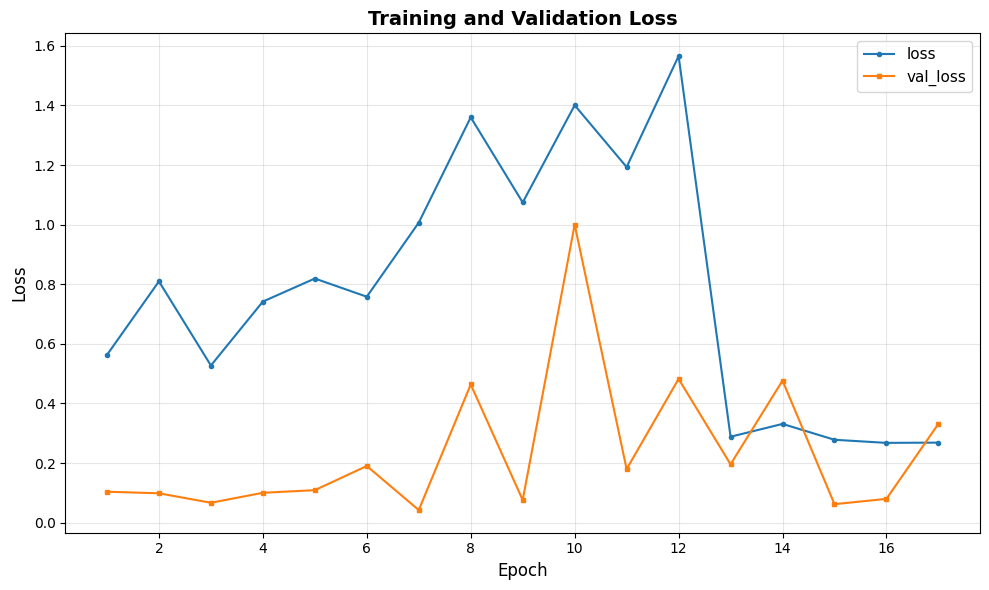


[PLOT 2] Accuracy vs Val Accuracy


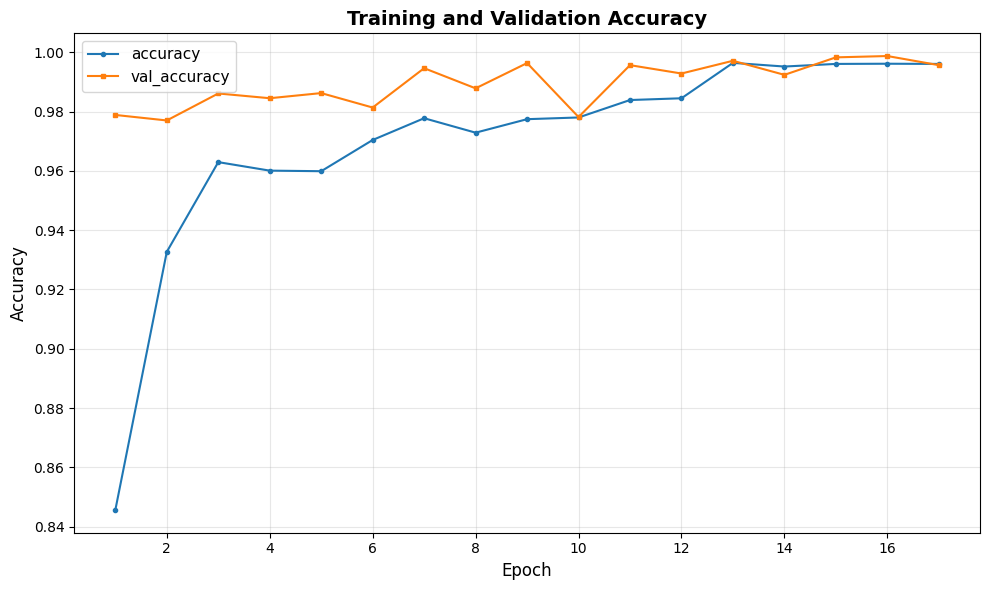


[PLOTS GENERATED] ✅

TRAINING PIPELINE COMPLETE ✅

[FINAL SUMMARY]
  Model architecture: ShallowConvNet
  Total training samples: 62400
  Total validation samples: 15600
  Epochs completed: 17
  Final training loss: 0.2686
  Final validation loss: 0.3317
  Final training accuracy: 0.9961
  Final validation accuracy: 0.9956
  Best val_loss: 0.0425
  Model saved to: ad_shallowconvnet_final.keras



In [14]:
# Cell 12 — Train FINAL generalized model (uses pre-split + SMOTE-balanced train/val)

print("=" * 80)
print("CELL 12: TRAINING FINAL MODEL (UPDATED: uses X_train_bal/X_val_bal from Step 7)")
print("=" * 80)

print("\n[IMPORTING LIBRARIES]")
import numpy as np
print("✓ import numpy as np")

import matplotlib.pyplot as plt
print("✓ import matplotlib.pyplot as plt")

from tensorflow import keras
print("✓ from tensorflow import keras")

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
print("✓ from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger")

print("\n" + "=" * 80)
print("STEP 8: USING PRE-BALANCED TRAIN/VAL SETS (NO train_test_split HERE)")
print("=" * 80)

# -------------------------------------------------------------------
# IMPORTANT: These must already exist from UPDATED STEP 7:
#   X_train_bal, y_train_bal, X_val_bal, y_val_bal
# -------------------------------------------------------------------
required_vars = ["X_train_bal", "y_train_bal", "X_val_bal", "y_val_bal"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(
        f"Missing variables {missing}. "
        "Run UPDATED STEP 6 (split + train-only normalization) and UPDATED STEP 7 (SMOTE separately) first."
    )

print("\n[DATA CHECK] Confirming shapes...")
print(f"  X_train_bal: {X_train_bal.shape} | y_train_bal: {y_train_bal.shape}")
print(f"  X_val_bal  : {X_val_bal.shape}   | y_val_bal  : {y_val_bal.shape}")

print("\n[CLASS DISTRIBUTION CHECK]")
u_tr, c_tr = np.unique(y_train_bal.astype(int), return_counts=True)
u_va, c_va = np.unique(y_val_bal.astype(int), return_counts=True)
print(f"  Training set class counts   : {dict(zip(u_tr, c_tr))}")
print(f"  Validation set class counts : {dict(zip(u_va, c_va))}")

# Optional: assert both classes exist in val
if len(u_va) < 2:
    raise ValueError(
        f"Validation set has only one class after balancing: {dict(zip(u_va, c_va))}. "
        "Check your SMOTE step."
    )

print("\n" + "=" * 80)
print("BUILDING SHALLOWCONVNET MODEL")
print("=" * 80)

print(f"\n[MODEL CREATION] Calling create_shallowconvnet()...")
print(f"  input_shape = {X_train_bal.shape[1:]}")
print(f"  dropout_rate = 0.5")
print(f"  num_classes = 1")

model = create_shallowconvnet(
    input_shape=X_train_bal.shape[1:],
    dropout_rate=0.5,
    num_classes=1
)
print("\n✓ model = create_shallowconvnet(...)")

print("\n[MODEL COMPILATION]")
print("Compiling model with:")
print("  optimizer = Adam(learning_rate=0.001)")
print("  loss = 'binary_crossentropy'")
print("  metrics = [BinaryAccuracy(name='accuracy', threshold=0.5)]")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5)]
)
print("✓ model.compile(...)")

print("\n[MODEL BUILT] ✅")
print("\n[MODEL SUMMARY]")
print("-" * 80)
model.summary()
print("-" * 80)

print("\n" + "=" * 80)
print("SETTING UP CALLBACKS (MONITORING val_loss)")
print("=" * 80)

print("\n[CALLBACK 1] EarlyStopping")
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)
print("✓ early_stop = EarlyStopping(...)")

print("\n[CALLBACK 2] ReduceLROnPlateau")
lr_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)
print("✓ lr_plateau = ReduceLROnPlateau(...)")

print("\n[CALLBACK 3] CSVLogger")
csv_logger = CSVLogger("ad_final_train_log.csv", append=False)
print("✓ csv_logger = CSVLogger('ad_final_train_log.csv', append=False)")

print("\n[CALLBACKS LIST]")
callbacks = [early_stop, lr_plateau, csv_logger]
print(f"✓ callbacks ready ({len(callbacks)} total)")

print("\n" + "=" * 80)
print("STARTING TRAINING")
print("=" * 80)

print("\n[TRAINING CONFIGURATION]")
print(f"  Training samples: {X_train_bal.shape[0]}")
print(f"  Validation samples: {X_val_bal.shape[0]}")
print("  epochs = 200")
print("  batch_size = 16")
print("  shuffle = True")
print(f"  callbacks = {len(callbacks)} callbacks")

print("\n[TRAINING STARTED] Calling model.fit()...")
print("-" * 80)

history = model.fit(
    X_train_bal, y_train_bal,
    validation_data=(X_val_bal, y_val_bal),
    epochs=200,
    batch_size=16,
    shuffle=True,
    verbose=1,
    callbacks=callbacks
)

print("-" * 80)
print("\n✓ history = model.fit(...)")
print("\n[TRAINING COMPLETE] ✅")

print("\n" + "=" * 80)
print("SAVING FINAL MODEL")
print("=" * 80)

final_model_path = "ad_shallowconvnet_final.keras"
print(f"\n[SAVING MODEL] Path: {final_model_path}")
print("Calling model.save()...")

model.save(final_model_path)
print(f"✓ model.save('{final_model_path}')")

print("\n✅ SAVE COMPLETE")
print(f"  Final model saved: {final_model_path}")
print(f"  Training log saved: ad_final_train_log.csv")
print(f"  Normalization files: train_mean.pkl, train_std.pkl")

print("\n" + "=" * 80)
print("STEP 9: PLOTTING TRAINING CURVES")
print("=" * 80)

print("\n[EXTRACTING HISTORY]")
hist = history.history
print("✓ hist = history.history")
print(f"  Available keys: {list(hist.keys())}")

epochs_ran = range(1, len(hist["loss"]) + 1)
print(f"✓ epochs_ran = range(1, {len(hist['loss']) + 1})")
print(f"  Total epochs trained: {len(hist['loss'])}")

# -----------------------------
# Loss plot
# -----------------------------
print("\n[PLOT 1] Loss vs Val Loss")
plt.figure(figsize=(10, 6))
plt.plot(epochs_ran, hist["loss"], label="loss", marker="o", markersize=3)
plt.plot(epochs_ran, hist["val_loss"], label="val_loss", marker="s", markersize=3)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss", fontsize=14, fontweight="bold")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# Accuracy plot
# -----------------------------
print("\n[PLOT 2] Accuracy vs Val Accuracy")
acc_key = "accuracy" if "accuracy" in hist else "binary_accuracy"
val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_binary_accuracy"

plt.figure(figsize=(10, 6))
plt.plot(epochs_ran, hist[acc_key], label=acc_key, marker="o", markersize=3)
plt.plot(epochs_ran, hist[val_acc_key], label=val_acc_key, marker="s", markersize=3)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=14, fontweight="bold")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n[PLOTS GENERATED] ✅")

print("\n" + "=" * 80)
print("TRAINING PIPELINE COMPLETE ✅")
print("=" * 80)

print("\n[FINAL SUMMARY]")
print(f"  Model architecture: ShallowConvNet")
print(f"  Total training samples: {X_train_bal.shape[0]}")
print(f"  Total validation samples: {X_val_bal.shape[0]}")
print(f"  Epochs completed: {len(hist['loss'])}")
print(f"  Final training loss: {hist['loss'][-1]:.4f}")
print(f"  Final validation loss: {hist['val_loss'][-1]:.4f}")
print(f"  Final training accuracy: {hist[acc_key][-1]:.4f}")
print(f"  Final validation accuracy: {hist[val_acc_key][-1]:.4f}")
print(f"  Best val_loss: {min(hist['val_loss']):.4f}")
print(f"  Model saved to: {final_model_path}")

print("\n" + "=" * 80)
